This script is to convert the coordinates of the annotated images and annotations made **from** utm coordinates **to** images coordinates (that YOLO understands)

# 2. Convert from geographical space to image space

Since the objective of the home exam is to compare my annotations to the group's annotations, I will process the data in two batches, one per annotation set.

The following code piece is for my annotations

In [1]:
annotator_ID=20 # my folder ID

my_drive_path="/content/drive/MyDrive/HOME_EXAM/data"

path_to_tiles= my_drive_path+"/annotated_data/train/"+str(annotator_ID)
path_to_annotations=path_to_tiles+"/annotations_"+str(annotator_ID) +".shp"
path_to_tile_index=my_drive_path+"/map_data/train_data_tile_index.geojson"


# Define the class names and their corresponding IDs
class_names = ['tree']
class_ids = {'tree': 0}

And this piece is for the whole group's annotations

In [ ]:
annotator_ID="full_data" # change this to your folder ID

my_drive_path="/content/drive/MyDrive/HOME_EXAM/data"

path_to_tiles= my_drive_path+"/annotated_data/train/"+str(annotator_ID)+"/all_data"
path_to_annotations=my_drive_path+"/annotated_data/train/"+str(annotator_ID)+"/full_annotations"+".shp"
path_to_tile_index=my_drive_path+"/map_data/train_data_tile_index.geojson"


# Define the class names and their corresponding IDs
class_names = ['tree']
class_ids = {'tree': 0}

In [2]:
path_to_annotations

'/content/drive/MyDrive/HOME_EXAM/data/annotated_data/train/20/annotations_20.shp'

##2.1 Import libraries and read files in Drive

In [19]:
!pip install geopandas
!pip install rasterio
!pip install folium matplotlib mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import os, glob, json, shutil
import numpy as np
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd

# geospatial packages
import geopandas as gpd
from osgeo import gdal, ogr, osr
from shapely.geometry import Polygon
import rasterio as rio
import folium

# plotting libraries
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# define path to where osgeo utils (gdal_retile.py) are stored
path_osgeo_utils= "/usr/local/lib/python3.10/dist-packages/osgeo_utils"

In [36]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


## 2.2 Load annotations and tile index

In [37]:
# Read the annotations (.geojson) using geopandas
annotations = gpd.read_file(path_to_annotations)
# add class
annotations['class']='tree'

# Read the (.shp) file using geopandas
tile_index=gpd.read_file(path_to_tile_index)

In [38]:
inters = gpd.sjoin(annotations,tile_index, how='inner',predicate='intersects')

annotations[annotations.intersects(tile_index.geometry)]

/usr/local/lib/python3.10/dist-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1475: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


,id,class,geometry


In [39]:
m = tile_index.explore(color="blue")
m = annotations.explore(m=m, color="red", name="annotations")
m

Output hidden; open in https://colab.research.google.com to view.

In [40]:
# subset the tile index to include only tiles that are in the path_to_tiles
tiles_imgs=glob.glob(path_to_tiles+"/*.tif")
tiles_names = [os.path.basename(path) for path in tiles_imgs]
tile_index=tile_index[tile_index['ID'].isin(tiles_names)]


In [41]:
len(tile_index)

130

<Axes: >

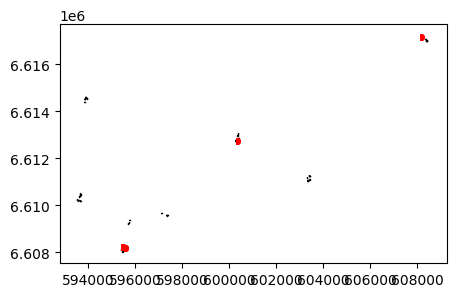

In [42]:
#Plot the annotations and tile index for a sanity check
fig, ax = plt.subplots(figsize=(5, 5))
tile_index.plot(ax=ax, edgecolor="black",facecolor="none")
annotations.plot(ax=ax, edgecolor="red",facecolor="none",lw=5)

## 2.3 Iterate through each of the tiles and export YOLO annotations for each tile (if annotations are available within that tile)

In [ ]:
# Remove those images from Godager that were corrupted
tile_index = tile_index[~tile_index['ID'].str.contains('Godager')]

tile_index

In [43]:
for i, tile in tile_index.iterrows():
  # iterate through all rows in tile index
  filename=tile['ID'] # get filename

  # get tile polygon
  tile_poly=tile_index[tile_index['ID']==filename]

  # select annotations that intersect with the ith tile
  ann_in_tile = gpd.sjoin(
    annotations,
    tile_poly,
    how='inner',
    predicate='intersects'
  )
  #ann_in_tile = annotations[annotations.intersects(tile.geometry)]

  # skip iteration if there are no annotations in a tile
  if len(ann_in_tile)==0:
    continue

  # get image size metadata
  #imgs= glob.glob(path_to_tiles+"/*.tif") # search for all .tif files in path_to_tiles
  if not os.path.exists(path_to_tiles+"/" + filename):
    print("skip")
    continue
  try:
    one_img= Image.open(path_to_tiles+"/" + filename) # read in the first one
  except:
    print("file corrupted")
    #continue
  one_img_array = np.array(one_img) # convert to a numpy array
  # get image width and height
  img_height_px= one_img_array.shape[0]
  img_width_px= one_img_array.shape[1]



  # Define the output file path
  output_file = path_to_tiles+"/"+os.path.splitext(filename)[0]+'.txt'
  print(output_file)

  # Open the output file for writing
  with open(output_file, 'w') as f:
    # Iterate through each polygon (j= 1,2,3,...) in the GeoJSON file
    for j, ann in ann_in_tile.iterrows():
      if ann['geometry'].geom_type == 'Polygon':
        polygons = [ann['geometry']]
      else:
        polygons = ann['geometry'].geoms

      # iterate through each vertex in the annotated bounding box
      for polygon in polygons:
        vertices = polygon.exterior.coords[:]

        # get tile extent
        tile_min_x, tile_min_y, tile_max_x, tile_max_y = tile['geometry'].bounds
        tile_width_m = round(tile_max_x - tile_min_x)
        tile_height_m = round(tile_max_y - tile_min_y)

        # get UTM coordinates of bounding box centre
        center_x_UTM = sum(coord[0] for coord in vertices) / len(vertices)
        center_y_UTM = sum(coord[1] for coord in vertices) / len(vertices)

        # convert them to coordinates relative to the tile size with origin 0, 0 in the upper left corner
        center_x= center_x_UTM - tile_min_x
        center_y= (tile_max_y-center_y_UTM)

        # get tile width and height in m
        min_x, min_y, max_x, max_y = polygon.bounds
        width_m = max_x - min_x
        height_m = max_y - min_y

        # Convert the coordinates to YOLO format
        x = center_x / tile_width_m
        y = center_y / tile_height_m
        w = width_m/tile_width_m
        h = height_m/tile_height_m

        #######################################################################
        # NEED TO ADD THE STUFF BELOW AND CHECK THAT IT WORKS!
        # replace negative values with zeros
        if x <0: x=0
        if y <0:y=0
        if w <0: w=0
        if h <0: h=0

        # replace values >1 values with 1
        if x >1: x=1
        if y >1:y=1
        if w >1: w=1
        if h >1: h=1

        # assign class ID (YOLO needs the classes to be numeric!)
        class_id = class_ids[ann['class']]

        # Write the annotation to the output file
        f.write(f"{class_id} {x} {y} {w} {h}\n")

0
1
/content/drive/MyDrive/HOME_EXAM/data/annotated_data/train/20/gjekstad_190410_p4p_08_05.txt
18
/content/drive/MyDrive/HOME_EXAM/data/annotated_data/train/20/kolstad_190414_p4p_35_10.txt
0
0
0
0
8
/content/drive/MyDrive/HOME_EXAM/data/annotated_data/train/20/kolstad_190414_p4p_37_17.txt
15
/content/drive/MyDrive/HOME_EXAM/data/annotated_data/train/20/kolstad_190414_p4p_37_19.txt
0
0
6
/content/drive/MyDrive/HOME_EXAM/data/annotated_data/train/20/gjekstad_190410_p4p_16_29.txt
3
/content/drive/MyDrive/HOME_EXAM/data/annotated_data/train/20/gjekstad_190410_p4p_16_27.txt
0
0
5
/content/drive/MyDrive/HOME_EXAM/data/annotated_data/train/20/kolstad_190414_p4p_41_20.txt
12
/content/drive/MyDrive/HOME_EXAM/data/annotated_data/train/20/BruuHvitsteen_190413_p4p_37_09.txt
0
16
/content/drive/MyDrive/HOME_EXAM/data/annotated_data/train/20/kolstad_190414_p4p_18_20.txt
2
/content/drive/MyDrive/HOME_EXAM/data/annotated_data/train/20/kolstad_190414_p4p_15_19.txt
11
/content/drive/MyDrive/HOME_EXAM/d

## 2.4 Plot the annotations overlayed to the ortho tile make sure that the export was correct

In [45]:
path_to_tiles

'/content/drive/MyDrive/HOME_EXAM/data/annotated_data/train/20'

In [ ]:
# read in one of the annotation files
annotation_plot_path= glob.glob(path_to_tiles+"/*.txt")[1]
filename_plot=os.path.splitext(os.path.basename(annotation_plot_path))[0]
with open(annotation_plot_path, "r") as f:
    annotations = f.readlines()

# read in the corresponding image tile
image_tile_plot  = cv2.imread(path_to_tiles+"/"+filename_plot+".tif")

# Parse annotations
annotations = [annotation.strip().split() for annotation in annotations]
annotations = [(annotation[0], float(annotation[1]), float(annotation[2]), float(annotation[3]), float(annotation[4])) for annotation in annotations]

# Overlay annotations on image
for annotation in annotations:
    label, x, y, w, h = annotation
    x1 = int((x - w/2) * image_tile_plot.shape[1])
    y1 = int((y - h/2) * image_tile_plot.shape[0])
    x2 = int((x + w/2) * image_tile_plot.shape[1])
    y2 = int((y + h/2) * image_tile_plot.shape[0])
    cv2.rectangle(image_tile_plot, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_tile_plot, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Plot image
plt.imshow(cv2.cvtColor(image_tile_plot, cv2.COLOR_BGR2RGB))
plt.show()


IndexError: ignored

Do the annotations look nice? Mine do at least

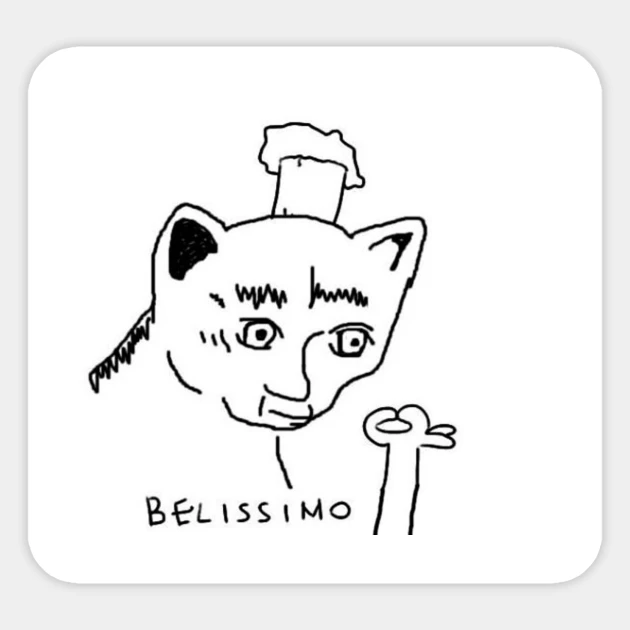